In [1]:
# https://www.tensorflow.org/decision_forests/tutorials/beginner_colab
# https://www.tensorflow.org/decision_forests/tutorials/advanced_colab
from google.cloud import bigquery

import pandas as pd
import numpy as np

import math
import os


In [2]:
import tensorflow as tf
print(tf.__version__)

2023-08-10 04:18:49.522150: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarni

2.12.0


In [3]:
#pip install tensorflow_decision_forests --upgrade --user
import tensorflow_decision_forests as tfdf
print(tfdf.__version__)



1.4.0


# Init Variable

In [4]:
labelCol='label_binary_severity'


projectId='pongthorn'
dataset_id='SMartML'

train_name='train2_incident'
test_name='test2_incident'

train_table_id=f"{projectId}.{dataset_id}.{train_name}"
test_tabel_id=f"{projectId}.{dataset_id}.{test_name}"
print(f"train-ds = {train_table_id}")
print(f"test-ds = {test_tabel_id}")

metric="accuracy"

_model='demo_binary_gbt_tf_model'
model_gs_path=f"gs://demo-tf-incident-pongthorn/{_model}"

cateCols=['sla','product_type','brand','service_type','incident_type']
numbericCols=['open_to_close_hour']
unusedCols=['id','severity_id','severity_name']  

train-ds = pongthorn.SMartML.train2_incident
test-ds = pongthorn.SMartML.test2_incident


# Load Train/Test Dataset from BQ

In [5]:
def load_data_bq(sql:str):
 
 query_result=client.query(sql)
 df=query_result.to_dataframe()
 df =df.drop(columns=unusedCols)
 df[labelCol]=df[labelCol].astype('int64') 
 df=df[[labelCol]+cateCols+numbericCols]   
  
 return df

client = bigquery.Client(project=projectId)

train=load_data_bq(f"SELECT * FROM {train_table_id}")
test=load_data_bq(f"SELECT * FROM {test_tabel_id}")

print(train.info())
print(test.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2347 entries, 0 to 2346
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   label_binary_severity  2347 non-null   int64  
 1   sla                    2347 non-null   object 
 2   product_type           2347 non-null   object 
 3   brand                  2347 non-null   object 
 4   service_type           2347 non-null   object 
 5   incident_type          2347 non-null   object 
 6   open_to_close_hour     2347 non-null   float64
dtypes: float64(1), int64(1), object(5)
memory usage: 128.5+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 587 entries, 0 to 586
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   label_binary_severity  587 non-null    int64  
 1   sla                    587 non-null    object 
 2   product_type           587 non-null    o

In [6]:
classes_train = list(train[labelCol].unique())
classes_test = list(test[labelCol].unique())

set_classes=set(classes_train) & set(classes_test)
classes=list(set_classes)
print(classes)

[0, 1]


1(Critical) in Train=1218 and  1(Critical) in Test=321
Train: Ratio of 1(Critical) to AllLabels is 0.52
Test: Ratio of 1(Critical) to AllLabels is 0.55


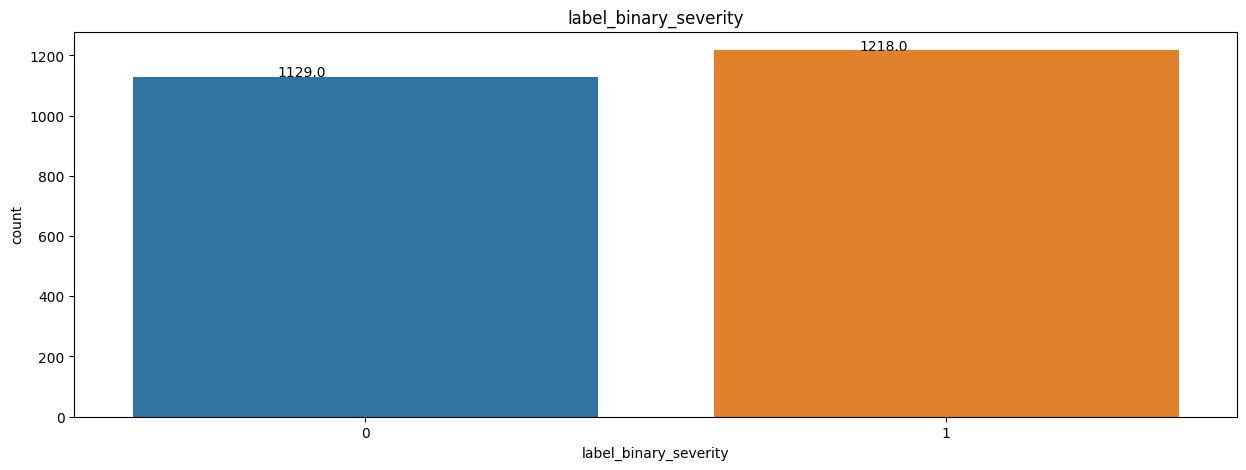

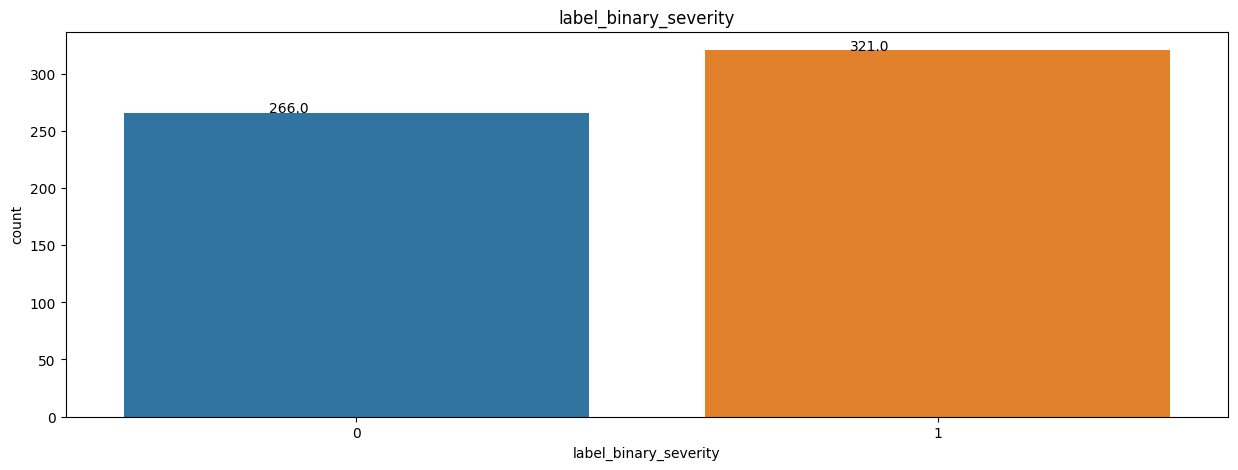

In [7]:
no_1_train=len(train.query(f"{labelCol}==1"))
no_1_test=len(test.query(f"{labelCol}==1"))
print(f"1(Critical) in Train={no_1_train} and  1(Critical) in Test={no_1_test}")

print(f"Train: Ratio of 1(Critical) to AllLabels is {round(no_1_train/len(train),2)}")
print(f"Test: Ratio of 1(Critical) to AllLabels is {round(no_1_test/len(test),2)}")

import seaborn as sns
import matplotlib.pyplot  as plt
def plot_label(df_):

    fig , ax = plt.subplots(figsize=(15,5))
    ax =sns.countplot(x=labelCol, data=df_,)
    for p in ax.patches:
       ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))
    plt.title(labelCol)
    plt.show()
        
plot_label(train)
plot_label(test)

In [8]:
train.tail(5)

,label_binary_severity,sla,product_type,brand,service_type,incident_type,open_to_close_hour
2342,0,24x7 4Hrs Response Time,Security,Trend Micro,Request,General Incident,0.333333
2343,0,24x7 4Hrs Response Time,Software,Trend Micro,Request,General Incident,168.150000
2344,0,24x7 6Hrs Resolution Time,Software,Trend Micro,Request,General Incident,5.483333
2345,0,24x7 4Hrs Response Time,Software,Trend Micro,Request,General Incident,220.333333
2346,0,24x7 6Hrs Resolution Time,Software,Trend Micro,Request,General Incident,0.883333


In [9]:
test.tail(5)

,label_binary_severity,sla,product_type,brand,service_type,incident_type,open_to_close_hour
582,0,24x7 4Hrs Response Time,Software,Trend Micro,Request,General Incident,7.400000
583,0,24x7 4Hrs Response Time,Software,Trend Micro,Request,Configuration Change,4.066667
584,0,24x7 4Hrs Response Time,Software,Trend Micro,Request,General Incident,96.483333
585,0,24x7 4Hrs Response Time,Software,Trend Micro,Request,General Incident,76.283333
586,0,24x7 4Hrs Response Time,Security,Trend Micro,Request,OS / Firmware,16.666667


# Convert dataframe to tensorflow dataset

In [10]:
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train, label=labelCol)
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test, label=labelCol)
print(train_ds)

<_PrefetchDataset element_spec=({'sla': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'product_type': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'brand': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'service_type': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'incident_type': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'open_to_close_hour': TensorSpec(shape=(None,), dtype=tf.float64, name=None)}, TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


# Build Model

In [11]:
# https://www.tensorflow.org/decision_forests/api_docs/python/tfdf/keras/GradientBoostedTreesModel
model=tfdf.keras.GradientBoostedTreesModel()
model.fit(x=train_ds)

Use /var/tmp/tmpwwcnhsad as temporary training directory
Reading training dataset...


[WARNING 23-08-10 04:19:12.5855 UTC gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-08-10 04:19:12.5867 UTC gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-08-10 04:19:12.5873 UTC gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
2023-08-10 04:19:12.673785: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype string and shape [2347]
	 [[{{node Placeholder/_4}}]]


Training dataset read in 0:00:04.766930. Found 2347 examples.
Training model...
Model trained in 0:00:00.403087
Compiling model...


[INFO 23-08-10 04:19:17.7357 UTC kernel.cc:1243] Loading model from path /var/tmp/tmpwwcnhsad/model/ with prefix 7a8644254fd943aa
[INFO 23-08-10 04:19:17.8032 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-08-10 04:19:17.8041 UTC kernel.cc:1075] Use fast generic engine
2023-08-10 04:19:17.863733: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype string and shape [2347]
	 [[{{node Placeholder/_4}}]]


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model compiled.


# Model Baisc Evaluate the model

In [12]:
model.compile(metrics=[metric])
evaluation = model.evaluate(test_ds, return_dict=True)
for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

2023-08-10 04:19:22.525301: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_6' with dtype int64 and shape [587]
	 [[{{node Placeholder/_6}}]]


1/1 [==============================] - 0s 406ms/step - loss: 0.0000e+00 - accuracy: 0.8058
loss: 0.0000
accuracy: 0.8058


# Model Self Evaluation

In [13]:
model.make_inspector().evaluation()

Evaluation(num_examples=None, accuracy=0.8333333134651184, loss=0.8041300773620605, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)

# Plotting the training logs

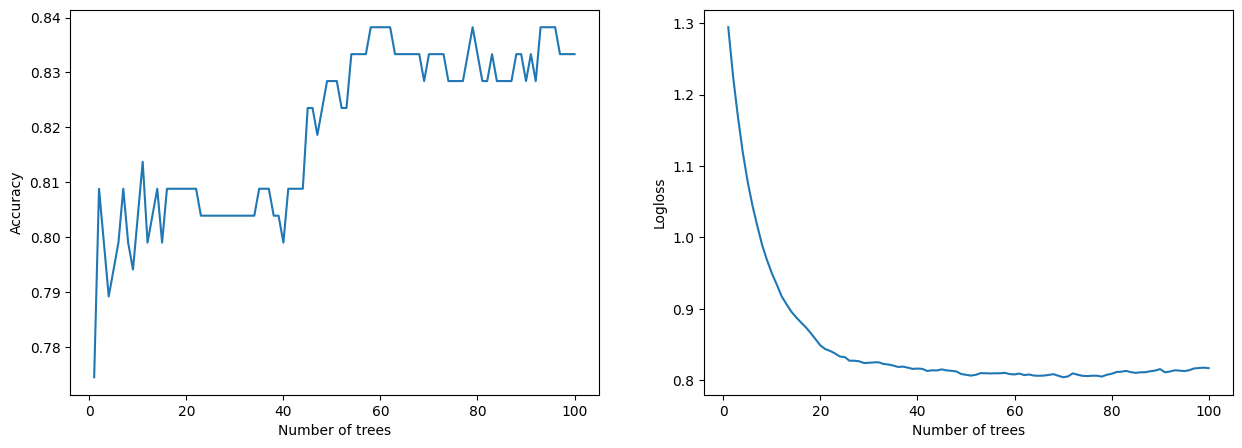

In [14]:
import matplotlib.pyplot as plt

logs = model.make_inspector().training_logs()

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Accuracy")

plt.subplot(1, 2, 2)
plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Logloss")

plt.show()



# Model Summary Inspect and debug decision forest models


In [15]:
model.summary()

Model: "gradient_boosted_trees_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "GRADIENT_BOOSTED_TREES"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (6):
	brand
	incident_type
	open_to_close_hour
	product_type
	service_type
	sla

No weights

Variable Importance: INV_MEAN_MIN_DEPTH:
    1.       "service_type"  0.370186 ################
    2.              "brand"  0.297120 ########
    3. "open_to_close_hour"  0.285377 #######
    4.      "incident_type"  0.263826 #####
    5.       "product_type"  0.229166 ##
    6.                "sla"  0.208043 

Variable Importance: NUM_AS_ROOT:
    1.       "service_type" 44.000000 ################
    2. "open_to_close_hour" 11.000000 ###
    3.              "brand"  6.000000 #
    4.       "product_type"  6.000000 #
 

In [16]:
inspector=model.make_inspector()

print("Model type:", inspector.model_type())
print("Number of trees:", inspector.num_trees())
print("Objective:", inspector.objective())
print("Input features:", inspector.features())

Model type: GRADIENT_BOOSTED_TREES
Number of trees: 70
Objective: Classification(label=__LABEL, class=None, num_classes=2)
Input features: ["brand" (4; #1), "incident_type" (4; #2), "open_to_close_hour" (1; #3), "product_type" (4; #4), "service_type" (4; #5), "sla" (4; #6)]


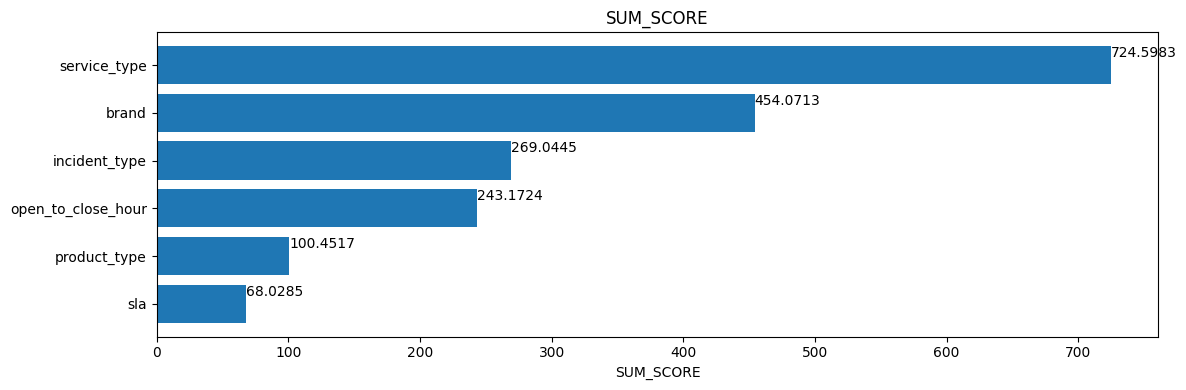

In [17]:


import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Mean decrease in AUC of the class 1 vs the others.
variable_importance_metric = "SUM_SCORE"
variable_importances = inspector.variable_importances()[variable_importance_metric]

# Extract the feature name and importance values.
#
# `variable_importances` is a list of <feature, importance> tuples.
feature_names = [vi[0].name for vi in variable_importances]
feature_importances = [vi[1] for vi in variable_importances]
# The feature are ordered in decreasing importance value.
feature_ranks = range(len(feature_names))

bar = plt.barh(feature_ranks, feature_importances, label=[str(x) for x in feature_ranks])
plt.yticks(feature_ranks, feature_names)
plt.gca().invert_yaxis()

# TODO: Replace with "plt.bar_label()" when available.
# Label each bar with values
for importance, patch in zip(feature_importances, bar.patches):
  plt.text(patch.get_x() + patch.get_width(), patch.get_y(), f"{importance:.4f}", va="top")

plt.xlabel(variable_importance_metric)
plt.title(variable_importance_metric)
plt.tight_layout()
plt.show()



# Plot the model asTree

In [19]:
tfdf.model_plotter.plot_model_in_colab(model, tree_idx=0, max_depth=3)



# Tune Model
Training a model with automated hyper-parameter tuning and automatic definition of the hyper-parameters (recommended approach)  https://www.tensorflow.org/decision_forests/tutorials/automatic_tuning_colab

In [30]:
# import time
# from datetime import date, timedelta, datetime 
# t_Start=time.time()

# print(f"Start tuning at {datetime.now()}")

# tuner = tfdf.tuner.RandomSearch( use_predefined_hps=True)
# tuned_model=tfdf.keras.GradientBoostedTreesModel(tuner=tuner)
# tuned_model.fit(x=train_ds,verbose=2)

# t_End=time.time()
# t_elapsed=(t_End-t_Start)/60/60
# print('Total execution : ',round(t_elapsed,2)) 
# print(datetime.now())

# # evaluation
# tuned_model.compile(["accuracy"])
# tuned_test_accuracy = tuned_model.evaluate(test_ds, return_dict=True, verbose=0)["accuracy"]
# print(f"Test accuracy with the TF-DF hyper-parameter tuner: {tuned_test_accuracy:.4f}")

# tuned_model.make_inspector().evaluation()

# # Display the tuning logs.
# tuning_logs = tuned_model.make_inspector().tuning_logs()
# tuning_logs.head()

In [31]:
# Export model to GCS
model.save(model_gs_path)

INFO:tensorflow:Assets written to: gs://demo-tf-incident-pongthorn/demo_binary_gbt_tf_model/assets


INFO:tensorflow:Assets written to: gs://demo-tf-incident-pongthorn/demo_binary_gbt_tf_model/assets
